# CS 4820
# Tutorial 8: Convolving a Gray Scale Image

### Load a Gray Scale Image

In [1]:
# allow multiple outputs be displayed for each cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

First of all, let's load an example gray scale image from [`scipy.misc`](https://docs.scipy.org/doc/scipy/reference/misc.html):

In [2]:
from scipy import misc
import matplotlib.pyplot as plt

img = misc.ascent()

plt.figure(figsize=(7, 7)) # Note: (7, 7) is the dimension of the figure shown below instead of dimension of the image itself
plt.imshow(img, cmap='gray');

In [3]:
img.shape # Note: (512, 512) is the dimension of the image

(512, 512)

A convolutional layer wants an order-4 tensor as input, so first of all we need to reshape our image so that it has 4 axes and not 2. 

We can add one axis of length <span style="color:red">1</span> for the input color channel (which is a grayscale pixel value between 0 and 255) and one axis of length <span style="color:blue">1</span> for the dataset index.

> Slide 4 of `CNN Intuition`: $(N, H, W, C)$=(<span style="color:blue">1</span>, 512, 512, <span style="color:red">1</span>)

In [4]:
img_tensor = img.reshape((1, 512, 512, 1))

### One convolutional Layer

Convolutional layers are available in [`keras.layers.Conv2D`](https://keras.io/layers/convolutional/). Let's apply a convolutional layer to the image we loaded above and see what happens.

First, let's import the `Conv2D` layer from keras:

In [5]:
from tensorflow.keras.layers import Conv2D

Let's start by applying one large flat filter of size 11x11 pixels. This operation should result in a blurring of the image because the pixels are averaged (technically they are totalled).

The syntax of[`Conv2D`](https://keras.io/layers/convolutional/) is:

       Conv2D(filters, kernel_size, input_shape, ...)

so we will specify <span style="color:purple">1</span> for the `filter` (aka. channels in output) of and (11, 11) for the `kernel_size`. We will also initialize all the weights to one by using `kernel_initializer='ones'`. Finally we will need to pass the input shape, since this is the first layer in the network. This is the shape of a __single image__, which in this case is (512, 512, <span style="color:red">1<span>).

> Slide 12 of `CNN Intuition`: $(H_f, W_f, C_i, C_o)$=(11, 11, <span style="color:red">1</span>, <span style="color:purple">1</span>)

In [6]:
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(Conv2D(1, (11,11), kernel_initializer='ones',
                 input_shape=(512, 512, 1)))
model.compile('adam', 'mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 502, 502, 1)       122       
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


__Q: Why `Output Shape = (None, 502, 502, 1)`?__

__A:__ 

The first value `None` is the number of images per patch in the training dataset, which varies (in this case, there is just one image).

The last value `1` is the number of channels in the output, which is going to be equal to the number of filters $C_o = 1$.

We will work on the size of each output image `502, 502` after the discussions on "padding" and "stride".

__Q: Why `Param # = 122`?__

__A:__ 

We have a model with one convolutional layer. 

On this layer, $C_o=1$ so there is one output channel. In other words, there is one filter, whose size is $H_f * W_f = 11 * 11$.

The number of input channels $C_i = 1$, therefore, the number of weights is going to be equal to the size of each filter (times the number of filters, which is one).

There is one theta (aka. the bias term) per neuron and there is one neuron per filter. So, the the number of thetas is going to be equal to $C_o$.

Therefore, the total number of parameters is:

$$Param\ \# = Weight\ \# + Theta\ \#= H_f * W_f * C_o * C_i + C_o = 11 * 11 * 1 * 1 + 1 = 122$$

We can apply the convolution to the image by running a forward pass:

In [7]:
img_pred_tensor = model.predict(img_tensor)

img_pred_tensor.shape

(1, 502, 502, 1)

To visualize the image we extract it from the tensor.

In [8]:
img_pred = img_pred_tensor[0, :, :, 0]

and we can use `plt.imshow` as before:

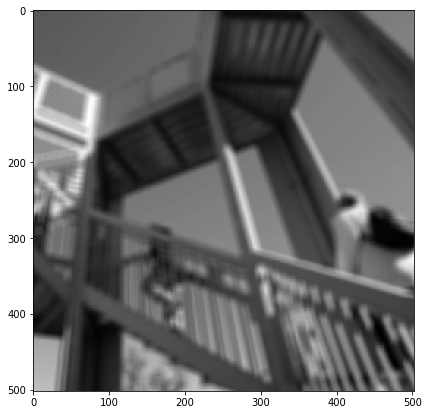

In [9]:
plt.figure(figsize=(7, 7))

plt.imshow(img_pred, cmap='gray');

As you can see the image is blurred, as we expected.


> TIP: try to change the initialization of the convolutional layer to something else [`keras.layers.Conv2D`](https://keras.io/layers/convolutional/). Then re-run the convolution and notice how the output image changes.

Great! We have just demonstrated that the convolution with a kernel will produce a new image, whose pixels will be a combination of the original pixels in a receptive field and the values of the weights and thetas in the kernel.

The user does not decide these weights, the network learns them through backpropagation! This allows a Neural Network to adapt and learn any pattern that is relevant to solving the task.

### Stacking Multiple Convolutional Layers

We can stack multiple convolutional layers to extract features from the original image that are not necessarily straight-forward for us human beings to comprehend/interpret.

To prevent vanishing gradient from happening, we use `relu` as the activation function on each convolutional layer. Not important here though since we won't train the model yet.

We can also initialize the kernels randomly.

In [11]:
model_2 = Sequential()
model_2.add(Conv2D(1, (11, 11), activation='relu', kernel_initializer='RandomNormal',
                 input_shape=(512, 512, 1)))
model_2.add(Conv2D(4, (5, 5), activation='relu', kernel_initializer='RandomUniform'))
model_2.add(Conv2D(2, (3, 3), activation='relu', kernel_initializer='TruncatedNormal'))
model_2.compile('adam', 'mse')
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 502, 502, 1)       122       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 498, 498, 4)       104       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 496, 496, 2)       74        
Total params: 300
Trainable params: 300
Non-trainable params: 0
_________________________________________________________________


__Q: Why `Param # = 104` on the second convolutional layer ?__

__A:__ 

One the second layer, $C_o=4$ so there are four output channels. In other words, there are four filters, each of whose size is $H_f * W_f = 5 * 5$.

The number of input channels $C_i = 1$, therefore, the number of weights is going to be equal to the size of each filter times the number of filters.

There is one theta (aka. the bias term) per neuron and there is one neuron per filter. So, the the number of thetas is going to be equal to $C_o$.

Therefore, the total number of parameters is:

$$Param\ \# = Weight\ \# + Theta\ \#= H_f * W_f * C_o * C_i + C_o = 5 * 5 * 4 * 1 + 4 = 104$$

__Q: Why `Param # = 74` on the third convolutional layer ?__

__A:__ 

One the third layer, $C_o=2$ so there are two output channels. In other words, there are two filters, each of whose size is $H_f * W_f= 3 * 3$.

The number of input channels $C_i = 4$, therefore, the number of weights is going to be equal to the size of each filter times the number of filters $C_o$ times $C_i$.

There is one theta (aka. the bias term) per neuron and there is one neuron per filter. So, the the number of thetas is going to be equal to $C_o$.

Therefore, the total number of parameters is:

$$Param\ \# = Weight\ \# + Theta\ \#= H_f * W_f * C_o * C_i + C_o = 3 * 3 * 2 * 4 + 2 = 74$$

We can apply all the convolution layers to the image by running a forward pass:

In [12]:
img_pred_tensor = model_2.predict(img_tensor)

img_pred_tensor.shape

(1, 496, 496, 2)

Finally, let's visualize the images that we could extract from the output tensor.

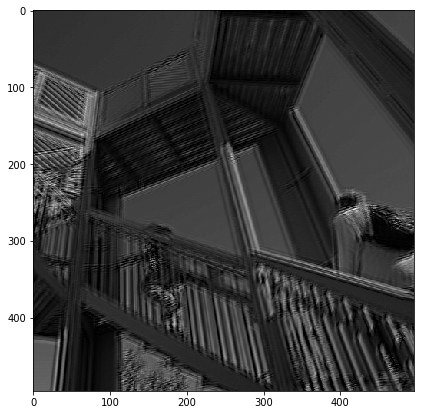

In [13]:
img_pred_1 = img_pred_tensor[0, :, :, 0]

plt.figure(figsize=(7, 7))

plt.imshow(img_pred_1, cmap='gray');

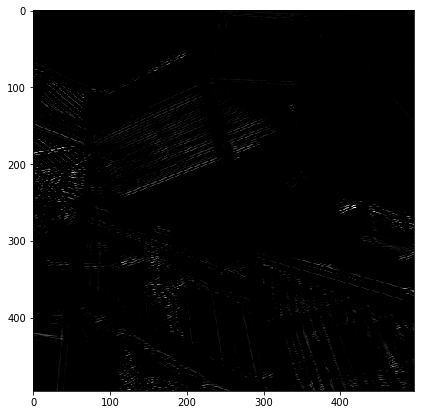

In [14]:
img_pred_2 = img_pred_tensor[0, :, :, 1]

plt.figure(figsize=(7, 7))

plt.imshow(img_pred_2, cmap='gray');